### Подготовка среды программирования

##### Установка необходимых библиотек

##### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import scipy as scipy
from copy import deepcopy
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic
import seaborn
import networkx as nx

### Визаулизация связей

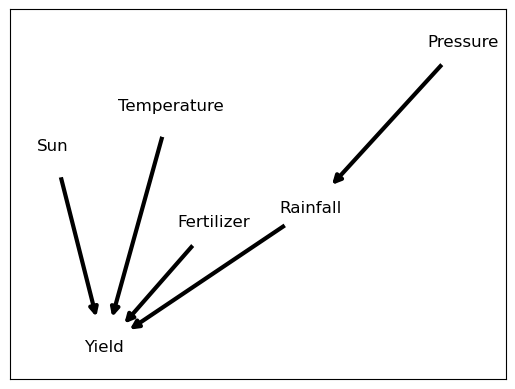

In [2]:
nx_options = {
    'node_color': 'white',
    'node_size': 2000,
    'width': 3,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

edges = [
    ('Pressure', 'Rainfall'),         
    ('Rainfall', 'Yield'),
    ('Sun', 'Yield'),
    ('Fertilizer', 'Yield'),
    ('Temperature', 'Yield'),

]


G = nx.DiGraph(directed = True)
G.add_edges_from(edges)


np.random.seed(8)
nx.draw_networkx(G, arrows = True, **nx_options)

### Генерация данных

##### Генерация контрольных переменных

In [3]:
np.random.seed(321)
n = 5000

##### Генерация переменной Temperature

[17. 31. 15.  6.  4.  9.  2.  7. 14. 31.]


<AxesSubplot:ylabel='Density'>

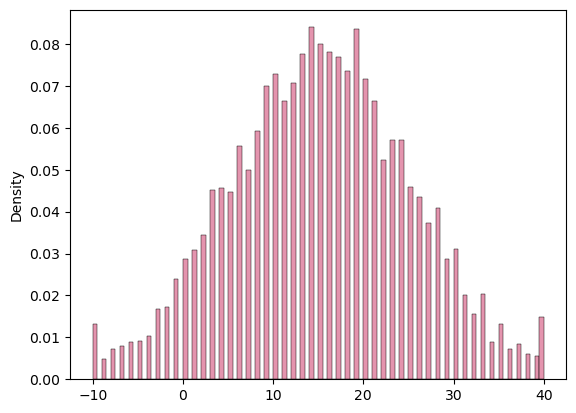

In [4]:
# Генерация переменной
temp = norm.rvs(size = n, loc = 15, scale = 10)
temp[temp >= 40] = 40
temp[temp <= -10] = -10
temp = np.round(temp)
print(temp[0:10])

# Распределение переменной
seaborn.histplot(temp,                 
                 stat = 'density',           
                 color = "palevioletred",   
                 label = "histogram",        
                 bins = 100)

##### Генерация переменной Fertilizer

In [5]:
# Генерация переменной
fert = np.random.binomial(n = 1, p = 0.8, size = n)
print(fert[0:10])

# Доля удобренного урожая
print(np.mean(fert))

[0 1 1 1 1 1 1 1 0 0]
0.8024


##### Генерация переменной Sun

[36. 29. 39. 31. 24. 36. 16. 29. 40. 29.]


<AxesSubplot:ylabel='Density'>

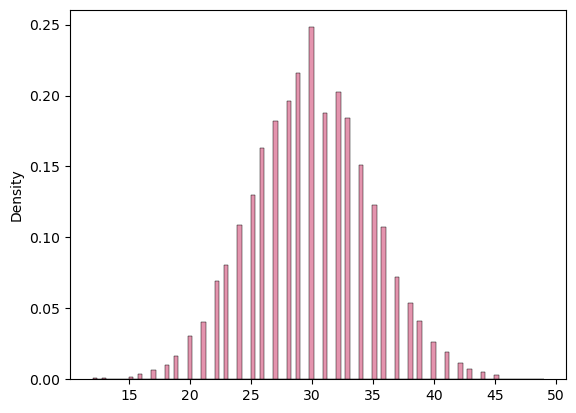

In [6]:
# Генерация переменной
sun = norm.rvs(size = n, loc = 30, scale = 5)
sun[sun >= 60] = 60
sun[sun <= 0] = 0
sun = np.round(sun)

# Вывод значений
print(sun[0:10])

# Распределение переменной
seaborn.histplot(sun,                 
                 stat = 'density',           
                 color = "palevioletred",   
                 label = "histogram",        
                 bins = 100)

##### Генерация инструментальной переменной

In [7]:
# Уравнение зависимости
press_index = 0.01*(temp /(100 - 0.2*sun)) + 0.1* temp * sun + 0 * fert - 50

# Преобразование в вероятности
press_prob = norm.cdf(press_index)

# Минимальное и максимальное значения вероятности
print(min(press_prob))
print(max(press_prob))

# Биномиальное распределение
press_1 = np.random.binomial(n = 1, p = press_prob, size = n)

# Вывод значений
print(press_1[0:10])

#Значения для модели
press = abs(press_1 - 1)
print(press)

0.0
1.0
[1 1 1 0 0 0 0 0 1 1]
[0 0 0 ... 0 1 1]


##### Генерация переменной эндогенности

[51. 34. 60. 50. 31. 51. 55. 56. 49. 58.]


<AxesSubplot:ylabel='Density'>

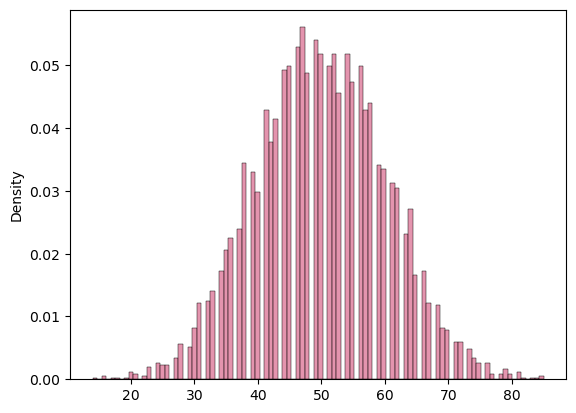

In [8]:
# Генерация переменной
hum = norm.rvs(size = n, loc = 50, scale = 10)
hum[hum >= 100] = 100
hum[hum <= 0] = 0
hum = np.round(hum)

# Вывод значений
print(hum[0:10])

# Распределение переменной
seaborn.histplot(hum,                 
                 stat = 'density',           
                 color = "palevioletred",   
                 label = "histogram",        
                 bins = 100)

##### Доля низкого атмосферного давления

In [9]:
print(np.mean(press))

0.5814


##### Генерация переменной воздействия

In [10]:
# Генерация стандартного нормального распределения
u = uniform.rvs(size = n)

# Функциональная зависимость для осадков
rain_index = 0.8 * temp * sun + 0 * fert + np.sqrt(hum)

# Низкое давление, вероятность осадков повышается
press1 = 1 
rain1_index = rain_index - 100 * press1
rain1_prob = logistic.cdf(rain1_index)
rain1 = (rain1_prob >= u).astype(int)

# Вероятность выпадения осадков при низком атмосферном давлении
np.mean(rain1)

0.8586

In [11]:
# Высокое давление, вероятность осадков снижается
press0 = 0 
rain0_index = rain_index - 100 * press0
rain0_prob = logistic.cdf(rain0_index)
rain0 = (rain0_prob >= u).astype(int)

# Вероятность отсутствия осадков при высоком атмосферном давлении
np.mean(rain0)

0.9402

##### Разделение осадков на группы

In [12]:
# Группы осадков
rain_type = np.empty(n, dtype = 'U25')
rain_type[(rain1 == 1) & (rain0 == 1)] = 'Always rain' #дождь идет при любом давлении
rain_type[(rain1 == 0) & (rain0 == 0)] = 'Never rain' #дождя нет при любом давлении
rain_type[rain1 > rain0] = 'True rain' #дождь только при низком давлении
rain_type[rain1 < rain0] = 'False rain' #дождь только при высоком давлении

# Количество наблюдений в каждой группе осадков
print(pd.value_counts(rain_type))

# Распределение осадков по группам
print(pd.DataFrame(data = np.array([rain0, rain1, rain_type]).transpose(),
                  columns = ['rain0', 'rain1', 'Группа осадков']))

Always rain    4293
False rain      408
Never rain      299
dtype: int64
     rain0 rain1 Группа осадков
0        1     1    Always rain
1        1     1    Always rain
2        1     1    Always rain
3        1     1    Always rain
4        1     0     False rain
...    ...   ...            ...
4995     1     1    Always rain
4996     1     1    Always rain
4997     1     1    Always rain
4998     1     0     False rain
4999     1     1    Always rain

[5000 rows x 3 columns]


##### Генерация реального дождя

In [13]:
# Функциональная зависимость реального дождя от значений атмосферного давления
rain = rain1 * press + rain0 * (1 - press)

# Вероятность того, что в реальности пойдет дождь 
print(np.mean(rain)) 

0.8586


##### Генерация случайной ошибки

In [14]:
# Экспоненциальное распределение
error1 = expon.rvs(size = n, scale = 10) - 10
error0 = t.rvs(size = n, df = 15) * 8

# Ситуация наличия осадков
g1_unobs = 0.8 * np.sqrt(hum)
g1_obs = 0.2 * sun * temp + fert
g1 = g1_unobs + g1_obs

# Ситуация отсутствия осадков
g0_unobs = 0.5 * np.sqrt(hum)
g0_obs = 0.5 * sun * temp + fert
g0 = g0_unobs + g0_obs


##### Генерация целевой переменной

In [15]:
# Урожайность в зависимости от факта наличия осадков
yield1 = g1 + error1
yield0 = g0 + error0

# Наблюдаемая урожайность
yield_total = yield1*rain + yield0 * (1 - rain)
yield_total[yield_total <= 0] = 0
yield_total[yield_total > 40] = 40

##### Объединение данных

In [16]:
df = pd.DataFrame({'yield' : yield_total, 'rain' : rain,
                  'temperature' : temp, 'sun' : sun,
                  'fertilizer' : fert})
df = df.loc[0:n, :]

df.head(100)

,yield,rain,temperature,sun,fertilizer
0,40.0,1,17.0,36.0,0
1,40.0,1,31.0,29.0,1
2,40.0,1,15.0,39.0,1
3,40.0,1,6.0,31.0,1
4,40.0,0,4.0,24.0,1
...,...,...,...,...,...
95,40.0,1,14.0,32.0,1
96,40.0,1,28.0,36.0,1
97,40.0,1,15.0,24.0,1
98,0.0,0,-3.0,35.0,0


##### Разделение целевой переменной и признаков

In [17]:
# Сохраним число наблюдений
n = df.index.size
print(n)

# Разделение переменных
target = df.loc[:, ['yield']]                     
features = df.loc[:, df.columns.drop('yield')]    
target = np.squeeze(target)

# Первые 10 наблюдений
df.head(10)

5000


,yield,rain,temperature,sun,fertilizer
0,40.000000,1,17.0,36.0,0
1,40.000000,1,31.0,29.0,1
2,40.000000,1,15.0,39.0,1
3,40.000000,1,6.0,31.0,1
4,40.000000,0,4.0,24.0,1
5,40.000000,1,9.0,36.0,1
6,35.182712,0,2.0,16.0,1
7,40.000000,1,7.0,29.0,1
8,40.000000,1,14.0,40.0,0
9,40.000000,1,31.0,29.0,0


##### Разделение выборки на обучающую и тестовую

In [18]:
# Подключение библиотеки
from sklearn.model_selection import train_test_split

# Разделение выборки
train_test_split(features, target, test_size = 0.2, random_state = 321)

[      rain  temperature   sun  fertilizer
 2088     1         24.0  34.0           1
 430      1         13.0  31.0           1
 2933     1         26.0  28.0           0
 2415     0         -2.0  37.0           1
 1322     1         14.0  35.0           1
 ...    ...          ...   ...         ...
 168      1         15.0  27.0           1
 1425     1         32.0  33.0           1
 3784     1         18.0  26.0           1
 2847     0         -3.0  36.0           1
 4220     1         31.0  28.0           1
 
 [4000 rows x 4 columns],
       rain  temperature   sun  fertilizer
 2041     1         16.0  42.0           1
 2607     1         14.0  26.0           1
 4675     1         38.0  38.0           1
 4629     1         10.0  33.0           1
 4615     1         17.0  25.0           1
 ...    ...          ...   ...         ...
 1354     1         19.0  32.0           1
 3155     1         19.0  22.0           1
 3652     1         32.0  37.0           0
 4647     1         11.0  

In [19]:
# Присвоим блокам соответстсующие названия
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 321)

# Сохранение числа наблюдений для обучающей и тестовой выборок
n_train = len(target_train)
n_test  = len(target_test)

# Возвращение итоговой сортировки индексов
features_train = features_train.reset_index(drop = True)
target_train   = target_train.reset_index(drop = True)
features_test  = features_test.reset_index(drop = True)
target_test    = target_test.reset_index(drop = True)
print(features_train, target_train, features_test, target_test)

      rain  temperature   sun  fertilizer
0        1         24.0  34.0           1
1        1         13.0  31.0           1
2        1         26.0  28.0           0
3        0         -2.0  37.0           1
4        1         14.0  35.0           1
...    ...          ...   ...         ...
3995     1         15.0  27.0           1
3996     1         32.0  33.0           1
3997     1         18.0  26.0           1
3998     0         -3.0  36.0           1
3999     1         31.0  28.0           1

[4000 rows x 4 columns] 0       40.0
1       40.0
2       40.0
3        0.0
4       40.0
        ... 
3995    40.0
3996    40.0
3997    40.0
3998     0.0
3999    40.0
Name: yield, Length: 4000, dtype: float64      rain  temperature   sun  fertilizer
0       1         16.0  42.0           1
1       1         14.0  26.0           1
2       1         38.0  38.0           1
3       1         10.0  33.0           1
4       1         17.0  25.0           1
..    ...          ...   ...         ...

##### Корреляционная матрица

In [115]:
# Построение корреляционной матрицы
df = pd.DataFrame({'yield' : yield_total, 'rain' : rain,
                  'temperature' : temp, 'sun' : sun,
                  'fertilizer' : fert, 'humidity' : hum,'pressure' : press})
df = df.astype(float)
print(df.astype(float).corr(method = 'pearson'))

                yield      rain  temperature       sun  fertilizer  humidity  \
yield        1.000000  0.769179     0.607631  0.018716   -0.003350 -0.005310   
rain         0.769179  1.000000     0.641959  0.026611   -0.005338  0.005845   
temperature  0.607631  0.641959     1.000000 -0.002634   -0.000337  0.006413   
sun          0.018716  0.026611    -0.002634  1.000000   -0.000561 -0.001363   
fertilizer  -0.003350 -0.005338    -0.000337 -0.000561    1.000000 -0.006613   
humidity    -0.005310  0.005845     0.006413 -0.001363   -0.006613  1.000000   
pressure    -0.298368 -0.344343    -0.765314 -0.210542    0.000431 -0.019148   

             pressure  
yield       -0.298368  
rain        -0.344343  
temperature -0.765314  
sun         -0.210542  
fertilizer   0.000431  
humidity    -0.019148  
pressure     1.000000  


### Классификация

##### Нормализация данных

In [20]:
# Создадим копию данных ДО нормализации
features_train_before = features_train.copy()
features_test_before  = features_test.copy()

# Создание объекта, который нормализует данные
import sklearn
import sklearn as preprocessing
scaler = sklearn.preprocessing.StandardScaler().fit(features_train)

# Нормализация данных из обучающей и тестовой выборок
features_train = scaler.transform(features_train_before)  
features_test  = scaler.transform(features_test_before)

### Метод  k-ближайших соседей

In [21]:
# Изменение формата данных
features_train = features_train.astype(int)
target_train = target_train.astype(int)
features_test = features_test.astype(int)
target_test = target_test.astype(int)

# Применение функции KNeighborsClassifier()
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3,      
                           metric = "minkowski", 
                           p = 2)                
knn.fit(features_train, target_train)

# Построение прогнозов
prediction_knn = knn.predict(features_train)
print(prediction_knn[0:10])

[40 40 40  0 40 40 40 19 40 40]


C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


##### Оценка точности прогнозов

In [22]:
# На обучающей выборке
ACC_knn_train = knn.score(features_train, target_train)

# На тестовой выборке
ACC_knn_test  = knn.score(features_test, target_test) 

# Вывод результатов
print(pd.DataFrame(data    = [ACC_knn_train, ACC_knn_test],
                   index   = ['Обучающая выборка', 'Тестовая выборка'],
                   columns = ['ACC']))

C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


                      ACC
Обучающая выборка  0.8615
Тестовая выборка   0.8630


C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


##### Применение кросс-валидации

In [23]:
# Гиперпараметры для перебора
hyperparameters = {'n_neighbors': [3, 5, 7, 9, 11, 13], 'p': [1, 2, 3, 4, 5, 5]}

# Подбор параметров с помощью функции GridSearchCV
from sklearn.model_selection import GridSearchCV

GSCV_knn = GridSearchCV(estimator = knn,               
                        param_grid = hyperparameters,  
                        scoring = "accuracy",          
                        cv = 5)                        
GSCV_knn.fit(features_train, target_train)

# Выберем лучшую по качеству модель с помощью свойства best_params_
hyperparameters_best = GSCV_knn.best_params_
print(hyperparameters_best)

C:\Users\Mi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior wil

{'n_neighbors': 7, 'p': 1}


C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

##### Обучение модели с оптимальными гиперпараметрами

In [24]:
# Обучение модели
knn2 = KNeighborsClassifier(n_neighbors = hyperparameters_best["n_neighbors"],
                            metric = "minkowski",
                            p = hyperparameters_best["p"])
knn2.fit(features_train, target_train)

# Оценка точности прогнозов на обучающей и тестовой выборках
ACC_knn2_train = knn2.score(features_train, target_train)  
ACC_knn2_test  = knn2.score(features_test, target_test)


C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

##### Сравнение моделей

In [25]:
# Качество прогнозов на тестовой выборке
print(pd.DataFrame(data    = [ACC_knn_test, ACC_knn2_test],
                   index   = ['Исходные гиперпараметры',
                              'Подобранные гиперпараметры'],
                   columns = ['ACC тестовой выборки']))

# Качество прогнозов на обучающей выборке
print(pd.DataFrame(data    = [ACC_knn_train, ACC_knn2_train],
                   index   = ['Исходные гиперпараметры',
                              'Подобранные гиперпараметры'],
                   columns = ['ACC обучающей выборки']))

                            ACC тестовой выборки
Исходные гиперпараметры                    0.863
Подобранные гиперпараметры                 0.875
                            ACC обучающей выборки
Исходные гиперпараметры                    0.8615
Подобранные гиперпараметры                 0.8665


##### Альтернативный критерий качества

##### Оценивание прогнозной урожайности

In [26]:
# Прогнозы на тестовой выборке
prediction_test_knn2 = knn2.predict(features_test)

# Трансформация в бинарную переменную
target_test_1 = []
for i in target_test:
    if i >= 40:
        target_test_1.append(1)
    else:
        target_test_1.append(0)
        
target_test_2 = np.array(target_test_1)

                
prediction_test_knn2_1 = []
for j in prediction_test_knn2:
    if j >= 40:
        prediction_test_knn2_1.append(1)
    else:
        prediction_test_knn2_1.append(0)
        
prediction_test_knn2_2 = np.array(prediction_test_knn2_1)
        

# Построение прогнозов различного вида вручную
TP = np.sum((target_test_2 == 1) & (prediction_test_knn2_2 == 1))
TN = np.sum((target_test_2 == 0) & (prediction_test_knn2_2 == 0))
FP = np.sum((target_test_2 == 0) & (prediction_test_knn2_2 == 1))
FN = np.sum((target_test_2 == 1) & (prediction_test_knn2_2 == 0))

# Сохранение результата
predictions_knn2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
print(predictions_knn2)


TP    830
TN     70
FP     87
FN     13
dtype: int32


C:\Users\Mi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


##### Подбор порога

In [27]:
# Цены прогнозов
prices = pd.Series([100, 50, 100, 50], index = ["TP", "TN", "FP", "FN"])

# Внутривыборочная прибыль от прогноза
profit_knn2 = np.sum(prices * predictions_knn2)
print(profit_knn2)

# Оценим условные вероятности на обучающей выборке
prob_knn2_train = knn2.predict_proba(features_train)

# Возможные значения порогов
thresholds_knn2 = np.unique(np.sort(prob_knn2_train))
print(thresholds_knn2)

# Число порогов
n_threshold_knn2 = thresholds_knn2.size

# Вектор для сохранения прибылей при различных порогах
profits_knn2 = np.zeros(n_threshold_knn2)

# Векторы различных видов прогнозов
TP_vec = np.zeros(n_threshold_knn2)
TN_vec = np.zeros(n_threshold_knn2)
FP_vec = np.zeros(n_threshold_knn2)
FN_vec = np.zeros(n_threshold_knn2)

# Рассчитаем прибыли для различных порогов
for i in range(0, n_threshold_knn2):
  # получаем прогнозы (на обучающей выборке) при соответствующем пороге
  prediction_knn_i = (prob_knn2_train >= thresholds_knn2[i]).astype(int)
  # аггрегируем результаты прогнозов
  predictions_knn_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]],
                                index = ["TP", "TN", "FP", "FN"])
  # считаем прибыль
  profits_knn2[i] = np.sum(prices * predictions_knn_i)
print(profits_knn2[i])

95850
[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]
0.0


##### Построение ROC-кривой

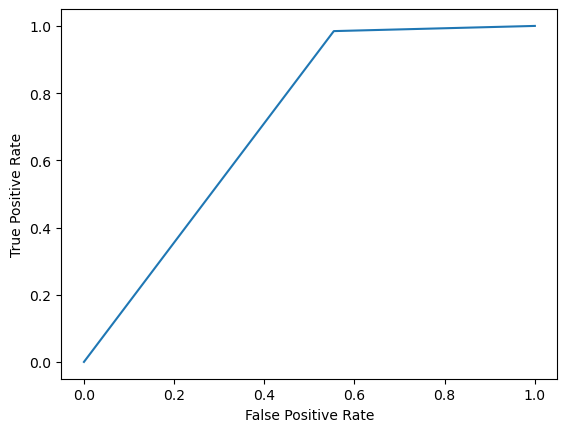

         AUC для тестовой выборки
Для knn                  0.715219


In [28]:
# Расчет метрик для построения ROC-кривой
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve (target_test_2, prediction_test_knn2_2)

# Построение ROC-кривой
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

# Расчет AUC
AUC_1 = metrics.roc_auc_score(target_test_2, prediction_test_knn2_2)
print(pd.DataFrame(data    = [AUC_1],
                   index   = ['Для knn'],
                   columns = ['AUC для тестовой выборки']))

##### Построение матрицы путаницы

#### Построение DAG

In [29]:
# Создание DAG
edges = [
    ('Pressure', 'Rainfall'),         
    ('Rainfall', 'Yield'),
    ('Sun', 'Yield'),
    ('Fertilizer', 'Yield'),
    ('Temperature', 'Yield')]

import bnlearn
DAG = bnlearn.make_DAG(edges)



[bnlearn] >bayes DAG created.


##### Обучение структуры Байесовской сети

In [30]:
# Разделение выборки на обучающую и тестовую
#features3_train, features3_test, target_train, target_test = train_test_split(
    #features, target, test_size = 0.2, random_state = 321)

# Объединение в один датафрейм
#df_train = features3_train.copy()

# Оценка параметров на обучающей выборке
#import bnlearn
#bn_train = bnlearn.parameter_learning.fit(DAG, df_train, methodtype = 'el')

# Оценка факторов
#bn = bnlearn.parameter_learning.fit(DAG, df, methodtype = 'el')


# Прогнозы на тестовой выборке
#predict_bn_test = bnlearn.predict(bn, df = features3_test, variables = features['temperature'])
#prediction_bn_test = np.array(predict_bn_test.loc[:, "temperature"])

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['rain' 'temperature' 'sun' 'fertilizer']]
[bnlearn] >Parameter learning> Computing parameters using [el]
[bnlearn] >Warning: methodtype [el] is unknown. Returning None.
[bnlearn] >Removing columns from dataframe to make consistent with DAG [['yield' 'rain' 'temperature' 'sun' 'fertilizer']]
[bnlearn] >Parameter learning> Computing parameters using [el]
[bnlearn] >Warning: methodtype [el] is unknown. Returning None.


Exception: [bnlearn] >Error: Input requires a dict that contains the key: model.

### Случайный лес

##### Решающие деревья

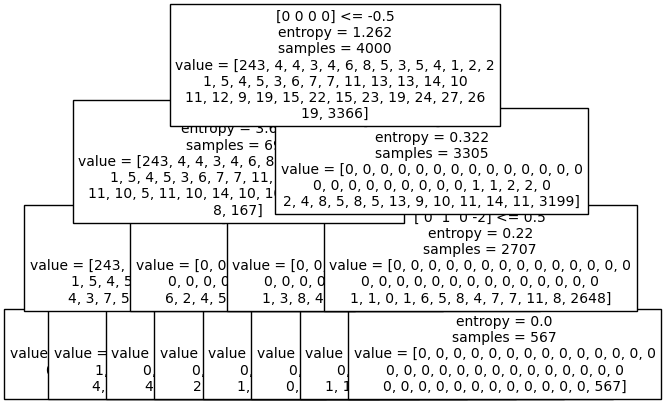

In [37]:
# Изменение формата данных
features_train = features_train.astype(int)
target_train = target_train.astype(int)
features_test = features_test.astype(int)
target_test = target_test.astype(int)

# Построение и обучение решающего дерева
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth = 3, criterion = 'entropy')
dt.fit(features_train, target_train)

# Визуализация дерева
plt.figure(figsize=(5, 5))
tree.plot_tree(dt, feature_names = features_train, fontsize = 10)
plt.show()

##### Построение прогноза и оценка точности прогноза

In [38]:
# Построение прогноза
prediction_dt = dt.predict(features_train)

# Оценка точности прогнозирования на обучающей и тестовой выборках
ACC_train_dt = dt.score(features_train, target_train)
ACC_test_dt = dt.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_train_dt, ACC_test_dt],
                   index   = ['ACC обучающая выборка',
                              'ACC тестовая выборка'],
                   columns = ['Точность прогноза']))

                       Точность прогноза
ACC обучающая выборка            0.87025
ACC тестовая выборка             0.88900


##### Кросс-валидация и подбор оптимальных гиперпараметров

In [39]:
# Потенциальные значения гиперпараметров
hyperparameters = {'max_depth': range(0, 30)}

# Кросс-валидация
GSCV_dt = GridSearchCV(estimator = dt,                 
                       param_grid = hyperparameters,   
                       scoring = "accuracy",           
                       cv = 5)                         
GSCV_dt.fit(features_train, target_train)

# Вывод лучших гиперпараметров
hyperparameters_best = GSCV_dt.best_params_
print(hyperparameters_best)

# Обучение модели с оптимальными параметрами
dt_best= tree.DecisionTreeClassifier(max_depth = 2,
                                  criterion = 'entropy')
dt_best.fit(features_train, target_train)

{'max_depth': 2}


DecisionTreeClassifier(criterion='entropy', max_depth=2)

##### Сравнение качества моделей

In [40]:
# На обучающей выборке
ACC_train_dt_best = dt_best.score(features_train, target_train)
print(pd.DataFrame(data    = [ACC_train_dt, ACC_train_dt_best],
                   index   = ['Неглубокое дерево',
                              'Дерево оптимальной глубины'],
                   columns = ['ACC обучающая выборка']))

# На тестовой выборке
ACC_test_dt_best = dt_best.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_dt, ACC_test_dt_best],
                   index   = ['Неглубокое дерево',
                              'Дерево оптимальной глубины'],
                   columns = ['ACC тестовая выборка']))

                            ACC обучающая выборка
Неглубокое дерево                         0.87025
Дерево оптимальной глубины                0.87025
                            ACC тестовая выборка
Неглубокое дерево                          0.889
Дерево оптимальной глубины                 0.889


##### Случайный лес

In [41]:
# Обучение случайного леса
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(max_depth = 20,         
                            max_features = "sqrt",  
                                                    
                            max_samples = 500,      
                            random_state = 321,     
                            criterion = 'entropy')  
                                                    
rf.fit(features_train, target_train)

# Прогнозирование
prediction_rf = dt.predict(features)
print(prediction_rf)

# Сравнение качества моделей на обучающей выборке
ACC_train_rf = rf.score(features_train, target_train)
print(pd.DataFrame(data    = [ACC_train_dt, ACC_train_dt_best, ACC_train_rf],
                   index   = ['Неглубокое дерево', 'Дерево оптимальной глубины',
                              'Случайный лес'],
                   columns = ['ACC на обучающей выборке']))

# Сравнение качества моделей на тестовой выборке
ACC_test_rf = rf.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_dt, ACC_test_dt_best, ACC_test_rf],
                   index   = ['Неглубокое дерево', 'Дерево оптимальной глубины',
                              'Случайный лес'],
                   columns = ['ACC на тестовой выборке']))

[40 40 40 ... 40 40 40]
                            ACC на обучающей выборке
Неглубокое дерево                            0.87025
Дерево оптимальной глубины                   0.87025
Случайный лес                                0.87175
                            ACC на тестовой выборке
Неглубокое дерево                             0.889
Дерево оптимальной глубины                    0.889
Случайный лес                                 0.878


##### Кросс-валидация

In [42]:
# Потенциальные значения гиперпараметров
hyperparameters = {'max_depth': range(0, 30)}

# Кросс-валидация
GSCV_dt = GridSearchCV(estimator = rf,                 
                       param_grid = hyperparameters,   
                       scoring = "accuracy",           
                       cv = 5)                         
GSCV_dt.fit(features_train, target_train) 

# Лучшие гиперпараметры
hyperparameters_best = GSCV_dt.best_params_

# Обучение модели

rf_best = RandomForestClassifier(max_depth = hyperparameters_best["max_depth"],         
                            max_features = "sqrt",  
                                                    
                            max_samples = 500,      
                            random_state = 321,     
                            criterion = 'entropy')  
                                                    
rf_best.fit(features_train, target_train)

# Оптимальная модель
print(hyperparameters_best)

ACC_test_rf_best = rf_best.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_rf_best],
                   index   = ['Оптимальный лес'],
                   columns = ['ACC тест']))

{'max_depth': 1}
                 ACC тест
Оптимальный лес     0.889


##### Прогноз для ожидаемой урожайности

In [43]:
# Прогнозы на тестовой выборке
prediction_test_rf_best = rf_best.predict(features_test)


# Трансформация в бинарную переменную
target_test_1 = []
for i in target_test:
    if i >= 40:
        target_test_1.append(1)
    else:
        target_test_1.append(0)
        
prediction_test_rf_best_1 = []
for j in prediction_test_rf_best:
    if j >= 40:
        prediction_test_rf_best_1.append(1)
    else:
        prediction_test_rf_best_1.append(0)
        
prediction_test_rf_best_2 = np.array(prediction_test_rf_best_1)
        

# Построение прогнозов различного вида вручную
TP = np.sum((target_test_2 == 1) & (prediction_test_rf_best_2 == 1))
TN = np.sum((target_test_2 == 0) & (prediction_test_rf_best_2 == 0))
FP = np.sum((target_test_2 == 0) & (prediction_test_rf_best_2 == 1))
FN = np.sum((target_test_2 == 1) & (prediction_test_rf_best_2 == 0))

# Сохранение результата
prediction_test_rf = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
print(prediction_test_rf)

TP    814
TN    117
FP     40
FN     29
dtype: int32


##### Построение ROC-кривой

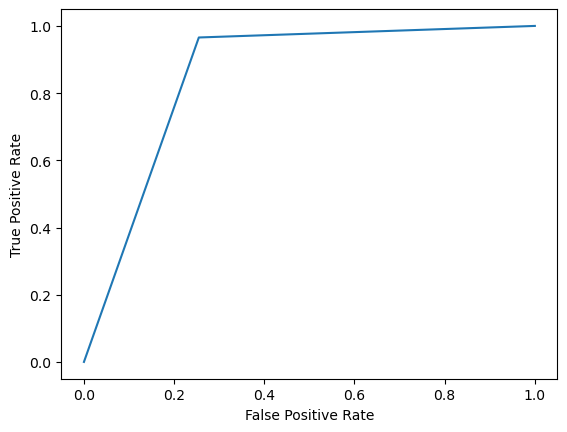

        AUC для тестовой выборки
Для rf                  0.855411


In [44]:
# Расчет метрик для построения ROC-кривой
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve (target_test_2, prediction_test_rf_best_2)

# Построение ROC-кривой
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

# Расчет AUC
AUC_2 = metrics.roc_auc_score(target_test_2, prediction_test_rf_best_2)
print(pd.DataFrame(data    = [AUC_2],
                   index   = ['Для rf'],
                   columns = ['AUC для тестовой выборки']))

### Логистическая регрессия

In [45]:
# Обучение логистической регрессии
from sklearn.linear_model import LogisticRegression  
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear',
                           fit_intercept = True)
logit.fit(features_train, target_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [46]:
# Выведем оценки коэффициентов
coef = pd.Series(logit.coef_[-0], index = features.columns)
print(coef)

# Выведем константу
intercept = logit.intercept_
print(intercept)

rain          -1.978696
temperature   -4.673082
sun            0.024297
fertilizer    -0.013139
dtype: float64
[-9.36147386 -7.62647504 -7.73805952 -7.73756902 -7.62643816 -7.76607742
 -7.72247628 -7.73746308 -7.98953185 -7.80783249 -7.73805482 -7.80942214
 -7.70338518 -7.73755797 -7.73761267 -7.80673828 -7.87557156 -7.60825624
 -7.42817583 -7.73838313 -7.08289504 -7.41948886 -6.33330065 -6.112936
 -6.32718214 -6.04125918 -6.21766535 -6.31196463 -6.20017443 -6.2301477
 -5.76340814 -5.84077089 -5.42499928 -6.06283056 -5.21457465 -5.39647036
 -5.21396396 -5.04792077 -5.20486715 -5.39282462  3.24143266]


In [47]:
# Оценки условных вероятностей
prob_logit = logit.predict_proba(features_train)[:, 1]
print(prob_logit[0:10])

[0.00047175 0.00047175 0.00021657 0.00745948 0.00047054 0.00021567
 0.00047175 0.00372558 0.00021567 0.00047175]


In [48]:
# Прогнозы
prediction_logit = logit.predict(features_train)
print(prediction_logit[0:10])

[40 40 40 40 40 40 40  0 40 40]


In [49]:
# Точность на тестовой выборке
ACC_test_logit = logit.score(features_test, target_test)

print(pd.DataFrame(data    = [ACC_test_logit],
                   index   = ['Логистическая регрессия'],
                   columns = ['ACC тест']))

                         ACC тест
Логистическая регрессия     0.885


##### Кросс-валидация

In [50]:
# Перебор значений гиперпараметров
hyperparameters = {'penalty': ['l1', 'l2', 'none', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Кросс-валидация
GSCV_log = GridSearchCV(estimator = logit,                 
                       param_grid = hyperparameters,   
                       scoring = "accuracy",           
                       cv = 5)                         
GSCV_log.fit(features_train, target_train) 


GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'penalty': ['l1', 'l2', 'none', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy')

In [51]:
# Лучшие гиперпараметры
hyperparameters_best = GSCV_log.best_params_
print(hyperparameters_best)

{'penalty': 'none', 'solver': 'lbfgs'}


In [52]:
# Обучение модели
logit_best = LogisticRegression(penalty = hyperparameters_best['penalty'], solver = hyperparameters_best['solver'],
                           fit_intercept = True)
logit_best.fit(features_train, target_train)

LogisticRegression(penalty='none')

In [53]:
# Точность на тестовой выборке
ACC_test_logit_best = logit_best.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_logit_best],
                   index   = ['Лучшая логистическая регрессия'],
                   columns = ['ACC тест']))

                                ACC тест
Лучшая логистическая регрессия     0.887


##### Прогноз для ожидаемой урожайности

In [54]:
# Прогнозы на тестовой выборке
prediction_test_logit_best = logit_best.predict(features_test)


# Трансформация в бинарную переменную
target_test_1 = []
for i in target_test:
    if i >= 40:
        target_test_1.append(1)
    else:
        target_test_1.append(0)
        
prediction_test_logit_best_1 = []
for j in prediction_test_logit_best:
    if j >= 40:
        prediction_test_logit_best_1.append(1)
    else:
        prediction_test_logit_best_1.append(0)
        
prediction_test_logit_best_2 = np.array(prediction_test_logit_best_1)
        

# Построение прогнозов различного вида вручную
TP = np.sum((target_test_2 == 1) & (prediction_test_logit_best_2 == 1))
TN = np.sum((target_test_2 == 0) & (prediction_test_logit_best_2 == 0))
FP = np.sum((target_test_2 == 0) & (prediction_test_logit_best_2 == 1))
FN = np.sum((target_test_2 == 1) & (prediction_test_logit_best_2 == 0))

# Сохранение результата
prediction_test_logit = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
print(prediction_test_logit)

TP    818
TN    108
FP     49
FN     25
dtype: int32


##### Построение ROC-кривой

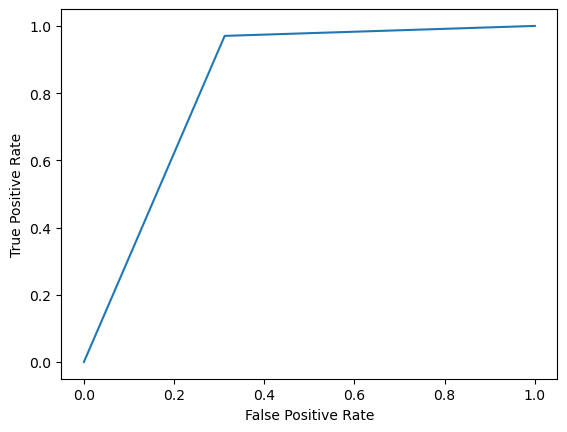

           AUC для тестовой выборки
Для logit                  0.829121


In [55]:
# Расчет метрик для построения ROC-кривой
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve (target_test_2, prediction_test_logit_best_2)

# Построение ROC-кривой
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

# Расчет AUC
AUC_3 = metrics.roc_auc_score(target_test_2, prediction_test_logit_best_2)
print(pd.DataFrame(data    = [AUC_3],
                   index   = ['Для logit'],
                   columns = ['AUC для тестовой выборки']))

##### Сравнение моделей по ACC

In [56]:
print(pd.DataFrame(data    = [ACC_knn2_train, ACC_test_rf_best, ACC_test_logit_best],
                   index   = ['knn', 'rf', 'logit'],
                   columns = ['ACC для тестовой выборки']))

       ACC для тестовой выборки
knn                      0.8665
rf                       0.8890
logit                    0.8870


##### Сравнение моделей по AUC

In [57]:
# Вывод результатов
print(pd.DataFrame(data    = [AUC_1, AUC_2, AUC_3],
                   index   = ['Для knn', 'Для rf','Для logit'],
                   columns = ['AUC для тестовой выборки']))

           AUC для тестовой выборки
Для knn                    0.715219
Для rf                     0.855411
Для logit                  0.829121


### Регрессия

##### Регрессионные деревья

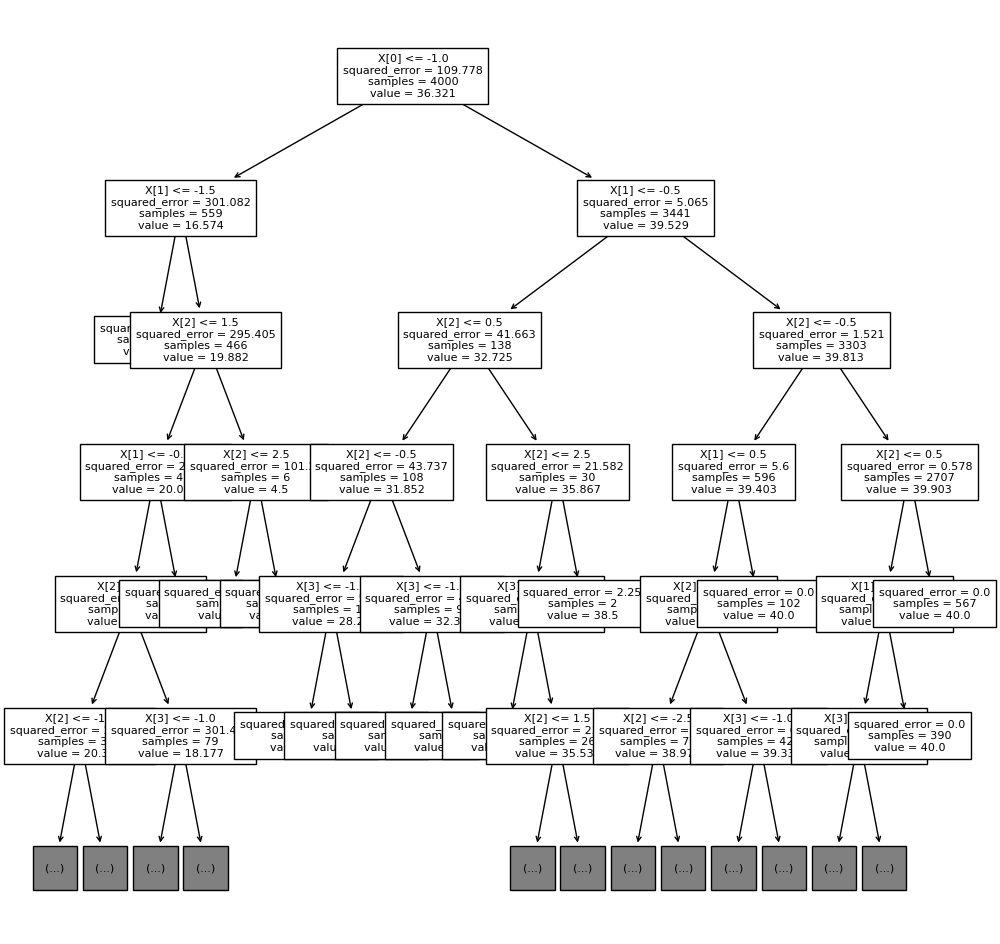

In [58]:
# Обучение регрессионного дерева
rt = tree.DecisionTreeRegressor(max_depth = 10, criterion = 'squared_error')
rt.fit(features_train, target_train) 
                                                         
# Визаулизация регрессионного дерева
plt.figure(figsize = (12, 12))
tree.plot_tree(rt, fontsize = 8, max_depth = 5)
plt.show()

##### Обучение случайного леса

In [59]:
# Обучение случайного леса
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth = 10,             
                            max_features = "sqrt",       
                                                         
                            max_samples = 500,           
                            random_state = 321,          
                            criterion = 'squared_error') 
                                                        
rfr.fit(features_train, target_train)


pred = rfr.predict(features_test)


# Оценка качества прогнозов
ACC_test_rfr = rfr.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_rfr],
                   index   = ['Регрессионный лес'],
                   columns = ['ACC тест']))

# Оценка качесвта прогнозов с помощью RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt


                   ACC тест
Регрессионный лес  0.726693


##### Кросс-валидация

In [60]:
# Потенциальные значения гиперпараметров
hyperparameters = {'max_depth': range(1, 30)}

# Кросс-валидация
GSCV_rfr = GridSearchCV(estimator = rfr,                 
                       param_grid = hyperparameters,   
                       scoring = "accuracy",           
                       cv = 5)                         
GSCV_rfr.fit(features_train, target_train) 

# Лучшие гиперпараметры
hyperparameters_best = GSCV_rfr.best_params_

In [61]:
# Лучшие гиперпараметры
hyperparameters_best = GSCV_rfr.best_params_
print(hyperparameters_best)

{'max_depth': 1}


In [62]:
# Обучение с оптимальными гиперпараметрами
rfr_best = RandomForestRegressor(max_depth = hyperparameters_best['max_depth'],             
                            max_features = "sqrt",       
                                                         
                            max_samples = 500,           
                            random_state = 321,          
                            criterion = 'squared_error') 
                                                        
rfr_best.fit(features_train, target_train)

# Оценка качества прогнозов
ACC_test_rfr_best = rfr_best.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_rfr, ACC_test_rfr_best],
                   index   = ['Регрессионный лес', 'Лучший регрессионный лес'],
                   columns = ['ACC тест']))

                          ACC тест
Регрессионный лес         0.726693
Лучший регрессионный лес  0.615630


### МНК

In [63]:
# Оценка МНК-регрессии
from sklearn.linear_model import LinearRegression
ls = LinearRegression()
ls.fit(features_train, target_train)

# Прогнозные значения
predict_test_ls  = ls.predict(features_test)
print(predict_test_ls[0:10])

# Точность прогноза
ACC_test_ls = ls.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_ls],
                   index   = ['МНК-оценка'],
                   columns = ['ACC тест']))

[39.1173221  39.10030873 44.79272903 39.10030873 39.09180204 41.93375885
 17.07206691 38.92306147 17.07206691 39.10881541]
            ACC тест
МНК-оценка  0.664985


### Градиентный бустинг

In [64]:
# Обучение градиентного бустинга
from sklearn.ensemble import GradientBoostingClassifier
learning_rate = 0.5
n_estimators  = 50
max_depth     = 2
random_state  = 123
max_features  = None
gb = GradientBoostingClassifier(            
                                n_estimators = n_estimators,   
                                learning_rate = learning_rate, 
                                criterion = "friedman_mse",    
                                max_depth = max_depth,         
                                random_state = random_state,   
                                max_features = max_features)   
gb.fit(features_train, target_train)   

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=50,
                           random_state=123)

In [65]:
# Точность прогнозирования на тестовой выборке
ACC_test_gb = gb.score(features_test, target_test)
print(pd.DataFrame(data    = [ACC_test_gb],
                   index   = ['Градиентный бустинг'],
                   columns = ['ACC тест']))

                     ACC тест
Градиентный бустинг      0.85


##### Сравнение точности моделей

In [66]:
# Сравнение моделей
print(pd.DataFrame(data    = [ACC_test_rfr_best, ACC_test_ls, ACC_test_gb],
                   index   = ['Регрессионный лес', 'МНК-регрессия','Градиентный бустинг'],
                   columns = ['ACC тест']))

                     ACC тест
Регрессионный лес    0.615630
МНК-регрессия        0.664985
Градиентный бустинг  0.850000


### Эффекты воздействия

In [67]:
# Генерация случайной ошибки
error_yield0 = scipy.stats.norm.rvs(size = n, scale = 10, loc = 0)
error_yield1 = scipy.stats.expon.rvs(size = n, scale = 10, loc = 0) - 10

# Целевая переменная с учетом случайной ошибки
yield0 = g0 + error_yield0
yield1 = g1 + error_yield1

In [68]:
# Расчет истичнного эффекта воздействия
TE = yield1 - yield0
print(TE[0:10])

[-171.53673134 -273.70184284 -179.13056236  -57.73540756  -38.68027489
 -104.4640141     1.62893051  -43.56113309 -165.64931732 -250.56082797]


##### ATE, CATE, LATE

In [69]:
# Расчет среднего эффекта воздействия
ATE = np.mean(TE)

# Расчет условного среднего эффекта воздействия
CATE = g1 - g0

# Подготовка данных для расчета LATE
compliers = []
a = rain0 - rain1
b = np.array(a)
for number in b:
    if number > 0:
        compliers.append(number)
        
# Расчет локального среднего эффекта воздействия
LATE = np.mean(TE[compliers])

# Вывод результатов расчета
print(pd.DataFrame(data    = [ATE, CATE, LATE],
                   index   = ['ATE', 'CATE', 'LATE'],
                   columns = ['Значение эффекта воздействия']))


                           Значение эффекта воздействия
ATE                                         -132.855371
CATE  [-181.45757147143715, -267.9507144315464, -173...
LATE                                        -273.701843


##### ATE как разница в средних

In [70]:
# Наивная оценка ATE
ATE_naive = np.mean(yield0[rain == 1]) - np.mean(yield1[rain == 0])

# Сравнение результатов
print(pd.DataFrame(data    = [ATE, ATE_naive],
                   index   = ['ATE', 'ATE_naive'],
                   columns = ['Сравнение ATE']))

           Сравнение ATE
ATE          -132.855371
ATE_naive     266.413793


In [81]:
df = pd.DataFrame({'yield' : yield_total, 'rain' : rain,
                  'temperature' : temp, 'sun' : sun,
                  'fertilizer' : fert})
df = df.loc[0:n, :]

df.head(100)

,yield,rain,temperature,sun,fertilizer
0,40.0,1,17.0,36.0,0
1,40.0,1,31.0,29.0,1
2,40.0,1,15.0,39.0,1
3,40.0,1,6.0,31.0,1
4,40.0,0,4.0,24.0,1
...,...,...,...,...,...
95,40.0,1,14.0,32.0,1
96,40.0,1,28.0,36.0,1
97,40.0,1,15.0,24.0,1
98,0.0,0,-3.0,35.0,0


##### МНК

In [82]:
# МНК-оценивание урожайности в ситуации отсутствия дождя
import statsmodels.api as sm 
y0 = df.loc[rain == 0, ['yield']]
x0 = df.loc[rain == 0, df.columns.drop(['yield', 'rain'])]
x0 = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

# МНК-оценивание в ситуации, когда идет дождь
y1 = df.loc[rain == 1, ['yield']]
x1 = df.loc[rain == 1, df.columns.drop(['yield', 'rain'])]
x1 = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

# Оценка урожайности в ситуации наличия и отсутствия дождя с помощью МНК-оценок
x = df.loc[:, df.columns.drop(['yield', 'rain'])]
x = sm.add_constant(x)
  # МНК оценка E(yield0 | X) для всех наблюдений
yield0_ls = ls0.predict(x)
  # МНК оценка E(yield1 | X) для всех наблюдений
yield1_ls = ls1.predict(x)

# Оценка CATE
CATE_ls = np.array(yield1_ls - yield0_ls)

# Оценка ATE
ATE_ls = np.mean(CATE_ls)

# Вывод результатов расчета
print(pd.DataFrame(data    = [ATE_ls, CATE_ls],
                   index   = ['ATE МНК', 'CATE МНК'],
                   columns = ['Значение эффекта воздействия']))


                               Значение эффекта воздействия
ATE МНК                                          -31.222156
CATE МНК  [-37.756356779849234, -85.15766236133942, -31....


##### Взвешивание на обратные вероятности

In [99]:
# Подготовка данных
target = df.loc[:, ['rain']]
features = df.loc[:, df.columns.drop(['rain', 'yield'])]

# Подготовка логистической регрессии
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(penalty = 'none', solver = 'lbfgs',
                           fit_intercept = True)
logit.fit(features, target)

# Оценка условной вероятности P(rain = 1 | X)
prob_log = logit.predict_proba(features)[:, 1]
probs = []

# Замена нулей на очень маленькую вероятность, близкую к 0
for item in prob_log:
    if item == 0:
        probs.append(item + 0.00000000001)
    else:
        probs.append(item)

proba = []

# Замена единиц на очень большую вероятность, близкую к 1 
for i in probs:
    if i == 1:
        proba.append(i - 0.00000000001)
    else:
        proba.append(i)
        
prob = np.array(proba)


# Оценка псевдоисходов
yield_pseudo = (yield_total * rain) / prob - (yield_total * (1 - rain)) / (1 - prob)
print(np.min(yield_pseudo))

import statistics
mean = statistics.mean(yield_pseudo)
stdev = statistics.stdev(yield_pseudo)
lower_bound = mean - 3 * stdev
upper_bound = mean + 3 * stdev
print(lower_bound, upper_bound)

ATE_IPW = np.mean(yield_pseudo)
print(ATE_IPW)


-1025517142.1543946
-43714080.71166672 43303937.02178185
-205071.84494243615


##### Двойное машинное обучение

In [84]:
# Преобразуем данные для формата двойного машинного обучения
import doubleml as dml
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'yield',
                            d_cols = 'rain',
                            x_cols = ['sun'])
print(dml_standard_data)

# Оценим с помощью случайного леса
g_Y = RandomForestRegressor(n_estimators = 100,
                            max_depth = 20,
                            max_features = 1)
g_T = RandomForestClassifier(n_estimators = 100,
                             max_depth = 20,
                             max_features = 1)
# Подготовка объекта

dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                               apply_cross_fitting = True,
                               n_rep = 1,
                               n_folds = 5)

# Оценка параметров с помощью двойного машинного обучения
dml_standard.fit()

# Сохранение оценки
ATE_dml_standard = dml_standard.coef[0]


================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: yield
Treatment variable(s): ['rain']
Covariates: ['sun']
Instrument variable(s): None
No. Observations: 5000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 5 entries, yield to fertilizer
dtypes: float64(3), int32(2)
memory usage: 156.4 KB

                  Оценка эффекта воздействия
ATE                              -132.855371
ATE naive                         266.413793
ATE ls                            -31.222156
ATE dml standard                   23.663865


##### Оценка условных средних эффектов воздействия
##### Оценивание с помощью S-learner

In [109]:
# Подготовка данных
y = df.loc[:, ['yield']]
x = df.loc[:, df.columns.drop(['yield'])]

# Обучение модели
rf2 = RandomForestRegressor(n_estimators = 100,
                            max_depth = 20,
                            max_features = 1)
rf2.fit(x, y)

# Оценки для всех наблюдений
x0 = deepcopy(x)
x0["rain"] = 0
yield0_rf2 = rf2.predict(x0)

x1 = deepcopy(x)
x1["rain"] = 1
yield1_rf2 = rf2.predict(x1)

# оценки CATE
CATE_S = yield1_rf2 - yield0_rf2
print(CATE_S)


[1.21706817 0.         7.82789672 ... 0.         4.09213086 0.52247053]


##### Оценивание с помощью T-learner

In [108]:
# Подготовка модели
rf = RandomForestRegressor(n_estimators = 100,
                           max_depth = 20,
                           max_features = 1)

# МНК-оценивание урожайности в ситуации отсутствия дождя
import statsmodels.api as sm 
y0 = df.loc[rain == 0, ['yield']]
x0 = df.loc[rain == 0, df.columns.drop(['yield', 'rain'])]
x0 = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

# МНК-оценивание в ситуации, когда идет дождь
y1 = df.loc[rain == 1, ['yield']]
x1 = df.loc[rain == 1, df.columns.drop(['yield', 'rain'])]
x1 = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

# Обучение модели (отсутствие дождя)
rf.fit(x0, y0)
yield0_rf = rf.predict(x)


# Обучение модели (идет дождь)
rf.fit(x1, y1)
yield1_rf = rf.predict(x)


# Оценки CATE
CATE_T = yield1_rf - yield0_rf
print(CATE_T)


[ 1.66821569  0.         11.20799256 ...  0.          7.38386143
  0.50557916]


##### Оценивание с помощью X-learner

##### Метод трансформации классов

In [103]:
# Подготовка модели
rf3 = RandomForestRegressor(n_estimators = 100,
                            max_depth = 5,
                            max_features = 3)
rf3.fit(features, yield_pseudo)

# Оценки CATE (метод трансформации классов)
CATE_CT = rf3.predict(features)
print(CATE_CT)

[ 39.9908966   39.9908966   39.9908966  ...  39.9908966  -22.86057054
  39.9908966 ]


##### Метод, обладающий двойной устойчивостью

In [105]:
# Оценим ATE с помощью DR метода с двойной устойчивостью
ATE_DR = np.mean((yield1_rf - yield0_rf) + \
                 rain * (yield_total - yield1_rf) / prob - \
                 (1 - rain) * (yield_total - yield0_rf) / (1 - prob))
print(ATE_DR)

-1108.4610986698576


##### Вывод результатов оценивания среднего эффекта воздействия

In [106]:
# Вывод результата
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_IPW, ATE_dml_standard, ATE_DR],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE_IPW', 'ATE dml standard', 'ATE_DR'],
                   columns = ['Оценка эффекта воздействия']))

                  Оценка эффекта воздействия
ATE                              -132.855371
ATE naive                         266.413793
ATE ls                            -31.222156
ATE_IPW                       -205071.844942
ATE dml standard                   23.663865
ATE_DR                          -1108.461099


 ##### Вывод результатов оценивания условного среднего эффекта воздествия

In [112]:
# Вывод результата
print(CATE_S)
print(CATE_T)
print(CATE_CT)

[1.21706817 0.         7.82789672 ... 0.         4.09213086 0.52247053]
[ 1.66821569  0.         11.20799256 ...  0.          7.38386143
  0.50557916]
[ 39.9908966   39.9908966   39.9908966  ...  39.9908966  -22.86057054
  39.9908966 ]
